In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score, 
    f1_score, 
    accuracy_score,
    confusion_matrix,
    classification_report
)
import optuna
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 再現性のためのシード設定
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("ライブラリのインポート完了")

ライブラリのインポート完了


/home/takato/bita/bank/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# データ読み込み
train_df = pd.read_csv("/home/takato/bita/bank/data/train.csv")
test_df = pd.read_csv("/home/takato/bita/bank/data/test.csv")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df['y'].value_counts())
print(f"\nPositive rate: {train_df['y'].mean():.4f}")

Train shape: (27128, 18)
Test shape: (18083, 17)

Target distribution:
y
0    23954
1     3174
Name: count, dtype: int64

Positive rate: 0.1170


In [8]:
def feature_engineering(df, is_train=True):
    """
    特徴量エンジニアリング関数（ワンホットエンコーディング版）
    
    Parameters:
    -----------
    df : DataFrame
        処理対象のデータフレーム
    is_train : bool
        訓練データの場合True、テストデータの場合False
    
    Returns:
    --------
    df : DataFrame
        特徴量エンジニアリング済みのデータフレーム
    """
    df = df.copy()
    
    # ===== 1. 数値特徴量の変換 =====
    # 年齢グループ (スタージェンの公式に基づく最適ビン数: 16)
    # k = 1 + 3.322 * log10(n) = 1 + 3.322 * log10(27128) ≈ 16
    # 年齢範囲: 18-95歳を16グループに等幅分割
    df['age_group'] = pd.cut(df['age'], bins=16).astype(str)
    # LightGBMのエラー回避: 特殊文字を置換
    df['age_group'] = df['age_group'].str.replace(r'[(),.\[\] ]', '_', regex=True)
    
    # balance の対数変換（負の値があるため調整）
    df['balance_log'] = np.log1p(df['balance'] - df['balance'].min() + 1)
    df['balance_positive'] = (df['balance'] > 0).astype(int)
    df['balance_negative'] = (df['balance'] < 0).astype(int)
    
    # ===== 2. 時系列特徴量 =====
    # duration関連
    df['duration_per_day'] = df['duration'] / (df['day'] + 1)
    df['campaign_efficiency'] = df['duration'] / (df['campaign'] + 1)
    df['duration_log'] = np.log1p(df['duration'])
    
    # previous関連
    df['has_previous_contact'] = (df['pdays'] != -1).astype(int)
    df['previous_per_pdays'] = df['previous'] / (df['pdays'].replace(-1, 1) + 1)
    
    # ===== 3. 月のマッピングと周期性エンコーディング =====
    month_mapping = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    df['month_numeric'] = df['month'].map(month_mapping)
    df['month_sin'] = np.sin(2 * np.pi * df['month_numeric'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_numeric'] / 12)
    
    # ===== 4. ローン関連の特徴量 =====
    df['total_loans'] = (df['housing'] == 'yes').astype(int) + (df['loan'] == 'yes').astype(int)
    df['has_any_loan'] = (df['total_loans'] > 0).astype(int)
    
    # ===== 5. カテゴリカル特徴量の準備 =====
    # バイナリ変数を数値化
    binary_cols = ['default', 'housing', 'loan']
    for col in binary_cols:
        df[col] = df[col].map({'yes': 1, 'no': 0})
    
    # ワンホットエンコーディング対象のカテゴリカル変数
    categorical_cols = ['job', 'marital', 'education', 'contact', 'poutcome', 'age_group']
    
    # ===== 6. 相互作用特徴量（ワンホット化前に作成） =====
    df['job_education'] = df['job'].astype(str) + '_' + df['education'].astype(str)
    df['contact_month'] = df['contact'].astype(str) + '_' + df['month'].astype(str)
    
    # 相互作用特徴量もワンホット化対象に追加
    interaction_cols = ['job_education', 'contact_month']
    categorical_cols.extend(interaction_cols)
    
    # monthは既に周期性エンコーディングしたので削除
    df = df.drop(columns=['month', 'month_numeric'])
    
    return df, categorical_cols

# 特徴量エンジニアリングを適用
train_processed, categorical_cols = feature_engineering(train_df, is_train=True)
test_processed, _ = feature_engineering(test_df, is_train=False)

print("特徴量エンジニアリング完了")
print(f"Train shape: {train_processed.shape}")
print(f"\nカテゴリカル変数: {categorical_cols}")

特徴量エンジニアリング完了
Train shape: (27128, 32)

カテゴリカル変数: ['job', 'marital', 'education', 'contact', 'poutcome', 'age_group', 'job_education', 'contact_month']


In [9]:
# ワンホットエンコーディング実行
train_encoded = pd.get_dummies(train_processed, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_processed, columns=categorical_cols, drop_first=True)

# 訓練データとテストデータのカラムを揃える
# テストデータに存在しないカラムを追加（0で埋める）
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    if col != 'y':  # ターゲット変数以外
        test_encoded[col] = 0

# 訓練データに存在しないカラムを削除
extra_cols = set(test_encoded.columns) - set(train_encoded.columns)
test_encoded = test_encoded.drop(columns=list(extra_cols))

# カラムの順序を揃える
test_encoded = test_encoded[train_encoded.drop(columns=['y']).columns]

print(f"ワンホットエンコーディング後のTrain shape: {train_encoded.shape}")
print(f"ワンホットエンコーディング後のTest shape: {test_encoded.shape}")
print(f"\n総特徴量数: {train_encoded.shape[1] - 2}")  # id, yを除く

ワンホットエンコーディング後のTrain shape: (27128, 142)
ワンホットエンコーディング後のTest shape: (18083, 141)

総特徴量数: 140


In [10]:
# ターゲットと特徴量の分離
y = train_encoded['y']
X = train_encoded.drop(columns=['id', 'y'])
X_test = test_encoded.drop(columns=['id'])

print(f"特徴量数: {X.shape[1]}")
print(f"訓練データサンプル数: {X.shape[0]}")
print(f"テストデータサンプル数: {X_test.shape[0]}")

特徴量数: 140
訓練データサンプル数: 27128
テストデータサンプル数: 18083


In [11]:
def objective_lgb_cv(trial):
    """
    LightGBMのハイパーパラメータ最適化（交差検証版）
    """
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "n_estimators": 3000,
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "random_state": RANDOM_STATE,
        "class_weight": "balanced",  # 不均衡データ対応
        "boosting_type": "gbdt"
    }
    
    # 5-Fold Stratified Cross Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        preds = model.predict_proba(X_valid_fold)[:, 1]
        auc = roc_auc_score(y_valid_fold, preds)
        cv_scores.append(auc)
    
    # 平均AUCを返す
    return np.mean(cv_scores)

# Optuna最適化実行
print("ハイパーパラメータ最適化を開始します...")
study_lgb = optuna.create_study(direction="maximize", study_name="lgbm_cv")
study_lgb.optimize(objective_lgb_cv, n_trials=50, show_progress_bar=True)

print(f"\nBest CV AUC: {study_lgb.best_value:.5f}")
print(f"\nBest params:")
for key, value in study_lgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-11 23:39:14,307] A new study created in memory with name: lgbm_cv


ハイパーパラメータ最適化を開始します...


Best trial: 0. Best value: 0.930762:   2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

[I 2025-11-11 23:39:15,746] Trial 0 finished with value: 0.9307623340311725 and parameters: {'learning_rate': 0.07277859425082907, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 63, 'subsample': 0.933372901638837, 'colsample_bytree': 0.7149407266157795, 'reg_alpha': 9.120766108960946e-05, 'reg_lambda': 2.522674416180109e-06, 'min_split_gain': 0.10196802324714072}. Best is trial 0 with value: 0.9307623340311725.


Best trial: 0. Best value: 0.930762:   4%|▍         | 2/50 [00:03<01:33,  1.95s/it]

[I 2025-11-11 23:39:18,053] Trial 1 finished with value: 0.9304073814759622 and parameters: {'learning_rate': 0.06643664074237393, 'num_leaves': 129, 'max_depth': 3, 'min_child_samples': 85, 'subsample': 0.6707579689923601, 'colsample_bytree': 0.9002223431735961, 'reg_alpha': 0.027096206177567698, 'reg_lambda': 0.6609889641687815, 'min_split_gain': 0.03002438837251109}. Best is trial 0 with value: 0.9307623340311725.


Best trial: 0. Best value: 0.930762:   6%|▌         | 3/50 [00:08<02:34,  3.29s/it]

[I 2025-11-11 23:39:22,936] Trial 2 finished with value: 0.9296571658876358 and parameters: {'learning_rate': 0.014700743675407987, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.8527005234158807, 'colsample_bytree': 0.6112733408313316, 'reg_alpha': 0.0003594555437221908, 'reg_lambda': 2.148566632620408e-06, 'min_split_gain': 0.2554754234176817}. Best is trial 0 with value: 0.9307623340311725.


Best trial: 0. Best value: 0.930762:   8%|▊         | 4/50 [00:11<02:27,  3.21s/it]

[I 2025-11-11 23:39:26,028] Trial 3 finished with value: 0.9304913611220019 and parameters: {'learning_rate': 0.025700493846096805, 'num_leaves': 135, 'max_depth': 6, 'min_child_samples': 66, 'subsample': 0.7036311007273456, 'colsample_bytree': 0.988844793771696, 'reg_alpha': 2.3960595160229653e-07, 'reg_lambda': 0.0002339265185249398, 'min_split_gain': 0.25935275342085984}. Best is trial 0 with value: 0.9307623340311725.


Best trial: 0. Best value: 0.930762:  10%|█         | 5/50 [00:12<01:49,  2.43s/it]

[I 2025-11-11 23:39:27,082] Trial 4 finished with value: 0.9304345972468789 and parameters: {'learning_rate': 0.09002269207636446, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.7324497780142275, 'colsample_bytree': 0.868030661891015, 'reg_alpha': 0.6874218052459495, 'reg_lambda': 0.15200375798755866, 'min_split_gain': 0.8546848398897761}. Best is trial 0 with value: 0.9307623340311725.


Best trial: 0. Best value: 0.930762:  12%|█▏        | 6/50 [00:17<02:16,  3.10s/it]

[I 2025-11-11 23:39:31,471] Trial 5 finished with value: 0.9300650546528105 and parameters: {'learning_rate': 0.020121364794181126, 'num_leaves': 142, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.757703761545564, 'colsample_bytree': 0.9058031002700534, 'reg_alpha': 0.02909235078692842, 'reg_lambda': 3.7599100229966496, 'min_split_gain': 0.6962436532031993}. Best is trial 0 with value: 0.9307623340311725.


Best trial: 6. Best value: 0.931732:  14%|█▍        | 7/50 [00:21<02:37,  3.66s/it]

[I 2025-11-11 23:39:36,293] Trial 6 finished with value: 0.9317316323533698 and parameters: {'learning_rate': 0.015595145915823432, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 84, 'subsample': 0.6263040209952483, 'colsample_bytree': 0.6007631736414679, 'reg_alpha': 7.514637082441984e-07, 'reg_lambda': 7.094334992258496, 'min_split_gain': 0.8220435264533295}. Best is trial 6 with value: 0.9317316323533698.


Best trial: 6. Best value: 0.931732:  16%|█▌        | 8/50 [00:27<03:05,  4.41s/it]

[I 2025-11-11 23:39:42,300] Trial 7 finished with value: 0.9299604842845213 and parameters: {'learning_rate': 0.01063500942564961, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 33, 'subsample': 0.8377668051516005, 'colsample_bytree': 0.9867051312871191, 'reg_alpha': 0.00015323522208416689, 'reg_lambda': 3.4831241694096804e-08, 'min_split_gain': 0.1883930560475665}. Best is trial 6 with value: 0.9317316323533698.


Best trial: 6. Best value: 0.931732:  18%|█▊        | 9/50 [00:31<02:48,  4.12s/it]

[I 2025-11-11 23:39:45,789] Trial 8 finished with value: 0.9305804081874924 and parameters: {'learning_rate': 0.015867989047040336, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 97, 'subsample': 0.9497876551552221, 'colsample_bytree': 0.8850305463688346, 'reg_alpha': 8.468546280147944, 'reg_lambda': 3.972398596647093e-06, 'min_split_gain': 0.8776933907958917}. Best is trial 6 with value: 0.9317316323533698.


Best trial: 6. Best value: 0.931732:  20%|██        | 10/50 [00:33<02:16,  3.42s/it]

[I 2025-11-11 23:39:47,637] Trial 9 finished with value: 0.9296486861831161 and parameters: {'learning_rate': 0.07587289115605254, 'num_leaves': 147, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.9457605863104005, 'colsample_bytree': 0.7967812970159265, 'reg_alpha': 0.006640668695500045, 'reg_lambda': 5.797560232159029e-08, 'min_split_gain': 0.2787246359447425}. Best is trial 6 with value: 0.9317316323533698.


Best trial: 6. Best value: 0.931732:  22%|██▏       | 11/50 [00:35<01:54,  2.94s/it]

[I 2025-11-11 23:39:49,483] Trial 10 finished with value: 0.9317163282195497 and parameters: {'learning_rate': 0.04417234021265138, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 83, 'subsample': 0.622123902018496, 'colsample_bytree': 0.655331394396666, 'reg_alpha': 1.0168073236493483e-07, 'reg_lambda': 0.007948108568559716, 'min_split_gain': 0.6033186760103783}. Best is trial 6 with value: 0.9317316323533698.


Best trial: 11. Best value: 0.932502:  24%|██▍       | 12/50 [00:37<01:39,  2.63s/it]

[I 2025-11-11 23:39:51,403] Trial 11 finished with value: 0.9325015241223905 and parameters: {'learning_rate': 0.04322373303155426, 'num_leaves': 29, 'max_depth': 12, 'min_child_samples': 80, 'subsample': 0.610338951278792, 'colsample_bytree': 0.6020319152163148, 'reg_alpha': 1.8670804823885677e-08, 'reg_lambda': 0.012772437629931388, 'min_split_gain': 0.5771522776789607}. Best is trial 11 with value: 0.9325015241223905.


Best trial: 12. Best value: 0.932516:  26%|██▌       | 13/50 [00:39<01:32,  2.50s/it]

[I 2025-11-11 23:39:53,604] Trial 12 finished with value: 0.9325159267708389 and parameters: {'learning_rate': 0.039603159383787424, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 81, 'subsample': 0.6127876792192047, 'colsample_bytree': 0.6003550202800819, 'reg_alpha': 1.789761498661526e-08, 'reg_lambda': 0.00635998624062776, 'min_split_gain': 0.45052163595077277}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  28%|██▊       | 14/50 [00:41<01:23,  2.32s/it]

[I 2025-11-11 23:39:55,510] Trial 13 finished with value: 0.9318769265504298 and parameters: {'learning_rate': 0.04397599330978229, 'num_leaves': 27, 'max_depth': 12, 'min_child_samples': 73, 'subsample': 0.6052360860228286, 'colsample_bytree': 0.7119835482499424, 'reg_alpha': 1.0471956141513097e-08, 'reg_lambda': 0.0031644512882415252, 'min_split_gain': 0.47471140323308003}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  30%|███       | 15/50 [00:43<01:20,  2.29s/it]

[I 2025-11-11 23:39:57,743] Trial 14 finished with value: 0.9318372776515922 and parameters: {'learning_rate': 0.04057908505928552, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 98, 'subsample': 0.657441903655552, 'colsample_bytree': 0.6764257766248177, 'reg_alpha': 4.824846903250686e-06, 'reg_lambda': 0.0003923452773824801, 'min_split_gain': 0.4124770161916506}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  32%|███▏      | 16/50 [00:45<01:18,  2.30s/it]

[I 2025-11-11 23:40:00,073] Trial 15 finished with value: 0.9318789622587722 and parameters: {'learning_rate': 0.03544826140269216, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.7879054049340869, 'colsample_bytree': 0.7605556054674942, 'reg_alpha': 1.013970488350267e-08, 'reg_lambda': 0.03884096171867808, 'min_split_gain': 0.6138727082039916}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  34%|███▍      | 17/50 [00:47<01:11,  2.17s/it]

[I 2025-11-11 23:40:01,928] Trial 16 finished with value: 0.931862311695925 and parameters: {'learning_rate': 0.05447034228983384, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 73, 'subsample': 0.6938322403198433, 'colsample_bytree': 0.6520409464374569, 'reg_alpha': 5.642245437490904e-06, 'reg_lambda': 0.00019629646289556006, 'min_split_gain': 0.37473401790155936}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  36%|███▌      | 18/50 [00:50<01:16,  2.38s/it]

[I 2025-11-11 23:40:04,788] Trial 17 finished with value: 0.9324960463632694 and parameters: {'learning_rate': 0.027488526080789593, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.601981152240272, 'colsample_bytree': 0.7463524993261603, 'reg_alpha': 4.8459152381934395e-06, 'reg_lambda': 0.0030934311125153002, 'min_split_gain': 0.5776148941805226}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  38%|███▊      | 19/50 [00:52<01:05,  2.13s/it]

[I 2025-11-11 23:40:06,332] Trial 18 finished with value: 0.9309254364493738 and parameters: {'learning_rate': 0.05352314926586254, 'num_leaves': 37, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.8739506180989999, 'colsample_bytree': 0.6280070676664166, 'reg_alpha': 5.1724928138252796e-08, 'reg_lambda': 3.94121071044141e-05, 'min_split_gain': 0.7334468338280025}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  40%|████      | 20/50 [00:54<01:05,  2.20s/it]

[I 2025-11-11 23:40:08,698] Trial 19 finished with value: 0.9312057275756025 and parameters: {'learning_rate': 0.03086187808761058, 'num_leaves': 66, 'max_depth': 11, 'min_child_samples': 88, 'subsample': 0.9972950555682178, 'colsample_bytree': 0.6919526020614417, 'reg_alpha': 1.5434435380074764e-06, 'reg_lambda': 0.032860898866513784, 'min_split_gain': 0.9781358728505425}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  42%|████▏     | 21/50 [00:58<01:16,  2.63s/it]

[I 2025-11-11 23:40:12,350] Trial 20 finished with value: 0.9304032483270991 and parameters: {'learning_rate': 0.022489237711122274, 'num_leaves': 100, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.6552041282455741, 'colsample_bytree': 0.8226474623463235, 'reg_alpha': 6.222123413330059e-08, 'reg_lambda': 0.39040170845546573, 'min_split_gain': 0.4911642906541451}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  44%|████▍     | 22/50 [01:00<01:13,  2.64s/it]

[I 2025-11-11 23:40:14,994] Trial 21 finished with value: 0.9324719009541207 and parameters: {'learning_rate': 0.02818250183676533, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.6121910294106335, 'colsample_bytree': 0.7514126959169778, 'reg_alpha': 2.4016304280719414e-05, 'reg_lambda': 0.0038643109173476732, 'min_split_gain': 0.5902419275096945}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  46%|████▌     | 23/50 [01:03<01:09,  2.56s/it]

[I 2025-11-11 23:40:17,358] Trial 22 finished with value: 0.9317585659114277 and parameters: {'learning_rate': 0.036195403988555384, 'num_leaves': 29, 'max_depth': 11, 'min_child_samples': 42, 'subsample': 0.6430402561349217, 'colsample_bytree': 0.6412007511058851, 'reg_alpha': 4.812775427536196e-07, 'reg_lambda': 0.0011200742559496794, 'min_split_gain': 0.3796122123721837}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  48%|████▊     | 24/50 [01:04<01:00,  2.33s/it]

[I 2025-11-11 23:40:19,159] Trial 23 finished with value: 0.9316630254604418 and parameters: {'learning_rate': 0.0545259036717247, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 54, 'subsample': 0.701822520910038, 'colsample_bytree': 0.72623447335048, 'reg_alpha': 0.0015821140815425409, 'reg_lambda': 0.01895817565371245, 'min_split_gain': 0.5326103244639696}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  50%|█████     | 25/50 [01:07<01:02,  2.48s/it]

[I 2025-11-11 23:40:21,997] Trial 24 finished with value: 0.9321030135870008 and parameters: {'learning_rate': 0.024432937917848927, 'num_leaves': 51, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.6049945337394355, 'colsample_bytree': 0.671631550325207, 'reg_alpha': 8.962954741367538e-06, 'reg_lambda': 3.4632483783207684e-05, 'min_split_gain': 0.7227339258412533}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  52%|█████▏    | 26/50 [01:10<00:59,  2.47s/it]

[I 2025-11-11 23:40:24,424] Trial 25 finished with value: 0.931899208273175 and parameters: {'learning_rate': 0.033038356382328965, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 68, 'subsample': 0.7382831613111949, 'colsample_bytree': 0.6018781965863671, 'reg_alpha': 3.126113255506992e-08, 'reg_lambda': 0.10415727055311041, 'min_split_gain': 0.6461097992179237}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  54%|█████▍    | 27/50 [01:13<01:06,  2.89s/it]

[I 2025-11-11 23:40:28,289] Trial 26 finished with value: 0.931950837004675 and parameters: {'learning_rate': 0.019632458567062465, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 93, 'subsample': 0.6833825043986594, 'colsample_bytree': 0.8281938342140417, 'reg_alpha': 2.6928965257927827e-07, 'reg_lambda': 0.0009502477397278543, 'min_split_gain': 0.44878357700593496}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  56%|█████▌    | 28/50 [01:16<00:58,  2.65s/it]

[I 2025-11-11 23:40:30,403] Trial 27 finished with value: 0.9313280170273597 and parameters: {'learning_rate': 0.045146176386644865, 'num_leaves': 62, 'max_depth': 10, 'min_child_samples': 79, 'subsample': 0.6463790654082496, 'colsample_bytree': 0.7618740383701353, 'reg_alpha': 2.7317353265052854e-05, 'reg_lambda': 0.7150480002190888, 'min_split_gain': 0.5347244935347057}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  58%|█████▊    | 29/50 [01:17<00:50,  2.42s/it]

[I 2025-11-11 23:40:32,293] Trial 28 finished with value: 0.931454327319947 and parameters: {'learning_rate': 0.06105990965992165, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 32, 'subsample': 0.6004581480211548, 'colsample_bytree': 0.639017435484368, 'reg_alpha': 1.477505793323853e-06, 'reg_lambda': 0.008912846038280029, 'min_split_gain': 0.3368577615776275}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  60%|██████    | 30/50 [01:19<00:42,  2.10s/it]

[I 2025-11-11 23:40:33,652] Trial 29 finished with value: 0.9308869033163892 and parameters: {'learning_rate': 0.09985002607263872, 'num_leaves': 42, 'max_depth': 8, 'min_child_samples': 62, 'subsample': 0.7901808487851536, 'colsample_bytree': 0.7068443475204247, 'reg_alpha': 2.8289660215055486e-08, 'reg_lambda': 5.235605626656765e-05, 'min_split_gain': 0.1241568988552213}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  62%|██████▏   | 31/50 [01:21<00:40,  2.12s/it]

[I 2025-11-11 23:40:35,797] Trial 30 finished with value: 0.9315469066517128 and parameters: {'learning_rate': 0.03919941454983186, 'num_leaves': 32, 'max_depth': 12, 'min_child_samples': 92, 'subsample': 0.6328404460747034, 'colsample_bytree': 0.9498250905531058, 'reg_alpha': 5.2332758014878865e-05, 'reg_lambda': 0.0018983032890029256, 'min_split_gain': 0.5641407737540631}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  64%|██████▍   | 32/50 [01:24<00:40,  2.28s/it]

[I 2025-11-11 23:40:38,449] Trial 31 finished with value: 0.932285456559385 and parameters: {'learning_rate': 0.029077271141625987, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.6217788640040133, 'colsample_bytree': 0.7705493889921939, 'reg_alpha': 2.1061105294557877e-05, 'reg_lambda': 0.00642157712693317, 'min_split_gain': 0.6495258596724455}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  66%|██████▌   | 33/50 [01:26<00:40,  2.35s/it]

[I 2025-11-11 23:40:40,981] Trial 32 finished with value: 0.9316819135428327 and parameters: {'learning_rate': 0.029143801149787128, 'num_leaves': 44, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.671549340465405, 'colsample_bytree': 0.7253222484200984, 'reg_alpha': 2.9490828899817323e-06, 'reg_lambda': 0.08321449861617904, 'min_split_gain': 0.7606551180415186}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  68%|██████▊   | 34/50 [01:29<00:40,  2.54s/it]

[I 2025-11-11 23:40:43,970] Trial 33 finished with value: 0.9318228015597768 and parameters: {'learning_rate': 0.027009413035389486, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 53, 'subsample': 0.6008735203058089, 'colsample_bytree': 0.801854719485313, 'reg_alpha': 0.00025672489804537196, 'reg_lambda': 0.01943102104255261, 'min_split_gain': 0.44732665092294216}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  70%|███████   | 35/50 [01:32<00:41,  2.75s/it]

[I 2025-11-11 23:40:47,216] Trial 34 finished with value: 0.9318944108934387 and parameters: {'learning_rate': 0.020291402696136475, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 38, 'subsample': 0.6673873426889898, 'colsample_bytree': 0.7377209286080618, 'reg_alpha': 0.000605427310016387, 'reg_lambda': 0.0007102527795652606, 'min_split_gain': 0.6671573347188066}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  72%|███████▏  | 36/50 [01:34<00:34,  2.47s/it]

[I 2025-11-11 23:40:49,021] Trial 35 finished with value: 0.9321773602480196 and parameters: {'learning_rate': 0.0483770009934862, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 66, 'subsample': 0.6279102939432203, 'colsample_bytree': 0.6254013832635512, 'reg_alpha': 1.6447438492574588e-07, 'reg_lambda': 0.00012836753195696304, 'min_split_gain': 0.5706388240394961}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  74%|███████▍  | 37/50 [01:37<00:33,  2.60s/it]

[I 2025-11-11 23:40:51,919] Trial 36 finished with value: 0.9319790391137976 and parameters: {'learning_rate': 0.0338433858780711, 'num_leaves': 75, 'max_depth': 12, 'min_child_samples': 59, 'subsample': 0.7283588392508803, 'colsample_bytree': 0.6761651362815078, 'reg_alpha': 0.0013308845804146723, 'reg_lambda': 6.689331917973097e-06, 'min_split_gain': 0.31406457255856546}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  76%|███████▌  | 38/50 [01:39<00:29,  2.45s/it]

[I 2025-11-11 23:40:54,032] Trial 37 finished with value: 0.9299903107865821 and parameters: {'learning_rate': 0.07342468055021875, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.7182599712548227, 'colsample_bytree': 0.8414589820891722, 'reg_alpha': 8.18396904133496e-05, 'reg_lambda': 0.004019616336420815, 'min_split_gain': 0.012876810922071935}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  78%|███████▊  | 39/50 [01:42<00:28,  2.62s/it]

[I 2025-11-11 23:40:57,029] Trial 38 finished with value: 0.9301184102195317 and parameters: {'learning_rate': 0.023063730684665402, 'num_leaves': 63, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8926045765511282, 'colsample_bytree': 0.743625119961177, 'reg_alpha': 0.08031130518243085, 'reg_lambda': 0.9472304873510862, 'min_split_gain': 0.7832733928844854}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  80%|████████  | 40/50 [01:47<00:32,  3.23s/it]

[I 2025-11-11 23:41:01,706] Trial 39 finished with value: 0.9315932498984099 and parameters: {'learning_rate': 0.01348251600005794, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.7546558751014119, 'colsample_bytree': 0.7963304438813262, 'reg_alpha': 8.045954738391824e-07, 'reg_lambda': 0.2742291227042879, 'min_split_gain': 0.5412110651036511}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  82%|████████▏ | 41/50 [01:51<00:31,  3.51s/it]

[I 2025-11-11 23:41:05,860] Trial 40 finished with value: 0.9310583800532598 and parameters: {'learning_rate': 0.017464834140562095, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 80, 'subsample': 0.6823280606029157, 'colsample_bytree': 0.6234454194098881, 'reg_alpha': 1.4816238139396012e-05, 'reg_lambda': 2.0868070821893965, 'min_split_gain': 0.6030485527725897}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  84%|████████▍ | 42/50 [01:54<00:25,  3.22s/it]

[I 2025-11-11 23:41:08,407] Trial 41 finished with value: 0.9321293499036468 and parameters: {'learning_rate': 0.02816596218828056, 'num_leaves': 46, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.6264842411796306, 'colsample_bytree': 0.7716403559069941, 'reg_alpha': 2.2050494242985664e-05, 'reg_lambda': 0.006583764856318246, 'min_split_gain': 0.6711332543709267}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  86%|████████▌ | 43/50 [01:56<00:20,  2.89s/it]

[I 2025-11-11 23:41:10,512] Trial 42 finished with value: 0.9319852336533678 and parameters: {'learning_rate': 0.038491619689757936, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 48, 'subsample': 0.6184036355382597, 'colsample_bytree': 0.7734780713883367, 'reg_alpha': 4.639202006240603e-05, 'reg_lambda': 0.002699967301318165, 'min_split_gain': 0.6354504470277179}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  88%|████████▊ | 44/50 [01:58<00:16,  2.72s/it]

[I 2025-11-11 23:41:12,839] Trial 43 finished with value: 0.9319118172925904 and parameters: {'learning_rate': 0.030163780561546703, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 42, 'subsample': 0.6448276909605195, 'colsample_bytree': 0.8558761875684131, 'reg_alpha': 3.1168198131687834e-07, 'reg_lambda': 0.012233704674107518, 'min_split_gain': 0.5003025175844614}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  90%|█████████ | 45/50 [02:01<00:13,  2.80s/it]

[I 2025-11-11 23:41:15,817] Trial 44 finished with value: 0.9312113159567721 and parameters: {'learning_rate': 0.0249367244658636, 'num_leaves': 43, 'max_depth': 11, 'min_child_samples': 57, 'subsample': 0.6154975559380077, 'colsample_bytree': 0.9303673787843372, 'reg_alpha': 0.00012857455308743352, 'reg_lambda': 0.056929326791187417, 'min_split_gain': 0.4225634928101779}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  92%|█████████▏| 46/50 [02:04<00:11,  2.78s/it]

[I 2025-11-11 23:41:18,574] Trial 45 finished with value: 0.9318187415737738 and parameters: {'learning_rate': 0.02766340980275233, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 51, 'subsample': 0.8307614787011878, 'colsample_bytree': 0.7890672968258284, 'reg_alpha': 1.7339943611425743e-06, 'reg_lambda': 2.0331056428333328e-07, 'min_split_gain': 0.6901658587252029}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  94%|█████████▍| 47/50 [02:06<00:08,  2.70s/it]

[I 2025-11-11 23:41:21,092] Trial 46 finished with value: 0.9322050878556354 and parameters: {'learning_rate': 0.031712902845379524, 'num_leaves': 34, 'max_depth': 10, 'min_child_samples': 36, 'subsample': 0.6589940567460073, 'colsample_bytree': 0.695348593649015, 'reg_alpha': 1.1789750631206248e-07, 'reg_lambda': 0.0004955199333909441, 'min_split_gain': 0.2093074140930221}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  96%|█████████▌| 48/50 [02:10<00:05,  2.87s/it]

[I 2025-11-11 23:41:24,336] Trial 47 finished with value: 0.9324624474315464 and parameters: {'learning_rate': 0.02118118650091309, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.6354081395547851, 'colsample_bytree': 0.7426639623247683, 'reg_alpha': 1.9028486769846116e-08, 'reg_lambda': 0.002467300220677317, 'min_split_gain': 0.5838059881860306}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516:  98%|█████████▊| 49/50 [02:17<00:04,  4.15s/it]

[I 2025-11-11 23:41:31,473] Trial 48 finished with value: 0.9293938059412244 and parameters: {'learning_rate': 0.01298320025990318, 'num_leaves': 78, 'max_depth': 3, 'min_child_samples': 32, 'subsample': 0.6363655065576089, 'colsample_bytree': 0.7444723788069102, 'reg_alpha': 2.0028467413991495e-08, 'reg_lambda': 0.0012718550869418623, 'min_split_gain': 0.5753200014102318}. Best is trial 12 with value: 0.9325159267708389.


Best trial: 12. Best value: 0.932516: 100%|██████████| 50/50 [02:20<00:00,  2.81s/it]

[I 2025-11-11 23:41:34,618] Trial 49 finished with value: 0.9318359688194304 and parameters: {'learning_rate': 0.022675358571504604, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 45, 'subsample': 0.6766220536196029, 'colsample_bytree': 0.6947099017110354, 'reg_alpha': 1.630105283739274e-08, 'reg_lambda': 0.0002197167463016702, 'min_split_gain': 0.4975357752775702}. Best is trial 12 with value: 0.9325159267708389.

Best CV AUC: 0.93252

Best params:
  learning_rate: 0.039603159383787424
  num_leaves: 33
  max_depth: 12
  min_child_samples: 81
  subsample: 0.6127876792192047
  colsample_bytree: 0.6003550202800819
  reg_alpha: 1.789761498661526e-08
  reg_lambda: 0.00635998624062776
  min_split_gain: 0.45052163595077277


In [12]:
# 最適パラメータの設定
best_params = study_lgb.best_params.copy()
best_params.update({
    "n_estimators": 3000,
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "random_state": RANDOM_STATE,
    "class_weight": "balanced",
    "boosting_type": "gbdt"
})

# 交差検証で学習し、各フォールドの予測を保存
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))
cv_scores = []
models = []

print("交差検証で学習を開始します...\n")

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
    print(f"Fold {fold + 1}/5")
    
    X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = lgb.LGBMClassifier(**best_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_valid_fold, y_valid_fold)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Out-of-Fold予測
    oof_predictions[valid_idx] = model.predict_proba(X_valid_fold)[:, 1]
    
    # テストデータ予測（平均を取るため）
    test_predictions += model.predict_proba(X_test)[:, 1] / 5
    
    # スコア計算
    fold_auc = roc_auc_score(y_valid_fold, oof_predictions[valid_idx])
    cv_scores.append(fold_auc)
    models.append(model)
    
    print(f"  Fold {fold + 1} AUC: {fold_auc:.5f}")
    print()

# 全体のOOFスコア
overall_auc = roc_auc_score(y, oof_predictions)
print(f"\n{'='*50}")
print(f"Overall OOF AUC: {overall_auc:.5f}")
print(f"Mean CV AUC: {np.mean(cv_scores):.5f} ± {np.std(cv_scores):.5f}")
print(f"{'='*50}")

交差検証で学習を開始します...

Fold 1/5
[100]	valid_0's auc: 0.933534
[200]	valid_0's auc: 0.934402
  Fold 1 AUC: 0.93464

Fold 2/5
[100]	valid_0's auc: 0.924473
[200]	valid_0's auc: 0.927596
[300]	valid_0's auc: 0.927555
  Fold 2 AUC: 0.92812

Fold 3/5
[100]	valid_0's auc: 0.924717
[200]	valid_0's auc: 0.92775
[300]	valid_0's auc: 0.927437
  Fold 3 AUC: 0.92798

Fold 4/5
[100]	valid_0's auc: 0.93053
[200]	valid_0's auc: 0.934381
[300]	valid_0's auc: 0.93441
  Fold 4 AUC: 0.93501

Fold 5/5
[100]	valid_0's auc: 0.934723
[200]	valid_0's auc: 0.936577
  Fold 5 AUC: 0.93683


Overall OOF AUC: 0.93237
Mean CV AUC: 0.93252 ± 0.00372


In [13]:
# 最適な閾値を探索
best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.3, 0.8, 0.01):
    pred_binary = (oof_predictions > threshold).astype(int)
    f1 = f1_score(y, pred_binary)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n最適閾値: {best_threshold:.3f}")
print(f"最適F1スコア: {best_f1:.5f}")

# 最適閾値での評価
oof_binary = (oof_predictions > best_threshold).astype(int)
print(f"\n=== 最適閾値での評価 ===")
print(f"Accuracy: {accuracy_score(y, oof_binary):.5f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y, oof_binary))
print(f"\nClassification Report:")
print(classification_report(y, oof_binary))


最適閾値: 0.730
最適F1スコア: 0.63110

=== 最適閾値での評価 ===
Accuracy: 0.89907

Confusion Matrix:
[[22048  1906]
 [  832  2342]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     23954
           1       0.55      0.74      0.63      3174

    accuracy                           0.90     27128
   macro avg       0.76      0.83      0.79     27128
weighted avg       0.92      0.90      0.91     27128



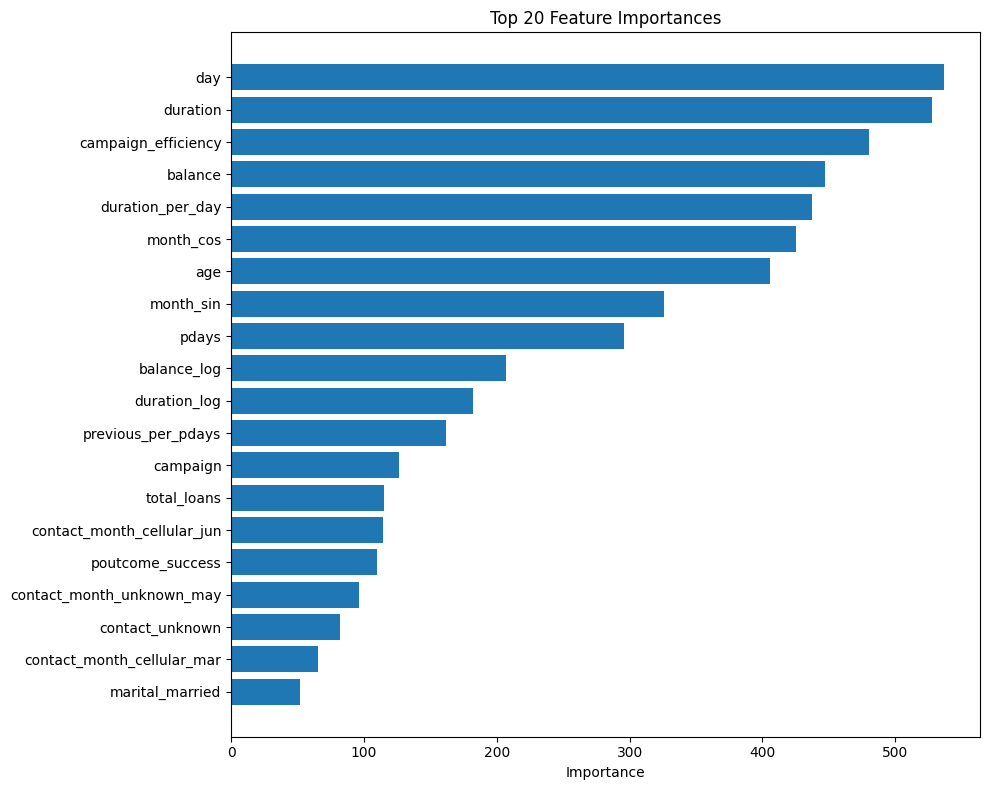


Top 20 重要な特徴量:
                        feature  importance
5                           day         537
6                      duration         528
14          campaign_efficiency         480
2                       balance         447
13             duration_per_day         437
19                    month_cos         425
0                           age         406
18                    month_sin         326
8                         pdays         296
10                  balance_log         207
15                 duration_log         182
17           previous_per_pdays         162
7                      campaign         126
20                  total_loans         115
110  contact_month_cellular_jun         114
41             poutcome_success         110
136   contact_month_unknown_may          96
39              contact_unknown          82
111  contact_month_cellular_mar          65
33              marital_married          52


In [14]:
# 特徴量重要度の可視化（最後のモデルを使用）
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': models[-1].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 20 重要な特徴量:")
print(feature_importance.head(20))

In [18]:
# 最適閾値で二値化
test_pred_binary = (test_predictions > best_threshold).astype(int)

# 提出ファイル作成
submission = pd.DataFrame({
    'id': test_df['id'],
    'y': test_pred_binary
})

submission.to_csv('/home/takato/bita/bank/data/onehot_lgbm.csv', index=False, header=False)

print("提出ファイルを作成しました: improved_onehot_cv_submission.csv")

提出ファイルを作成しました: improved_onehot_cv_submission.csv
